# Dataset 1 

In [135]:
import numpy as np
import pandas as pd
import re
import itertools
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import SVC
from sklearn import svm
from sklearn import tree
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sb
import nltk

## Exploring the Dataset

In [136]:
# loading the dataset to a pandas dataframe
news_dataset = pd.read_csv('Documents/COLLEGE/THESIS/DATASET/PH_dataset1.csv')

In [137]:
# number of (rows, columns) = (news articles, features)
news_dataset.shape

(3206, 2)

In [138]:
# print the first 5 rows of the dataframe
news_dataset.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


## Initializing Dataset

In [112]:
# replacing values in the 'label' column
news_dataset['label'] = news_dataset['label'].replace({'REAL': 0, 'FAKE': 1})

In [114]:
#removing the 'idd' column
#news_dataset.drop('idd', axis=1, inplace=True)

In [115]:
news_dataset.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


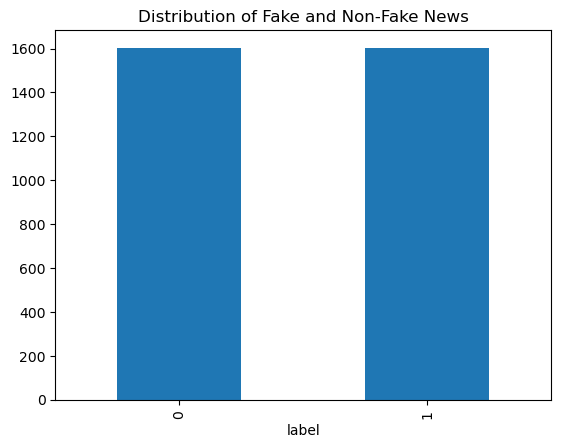

In [139]:
news_dataset['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Fake and Non-Fake News')
plt.show()

## Data Cleaning

### <font color=orange> Handling Missing Values

In [117]:
# counting the number of missing values in the dataset
news_dataset.isnull().sum()

label      0
article    0
dtype: int64

In [118]:
# replacing the null values with empty string
news_dataset = news_dataset.fillna('')

### <font color=orange>Removing Duplicate Entries

In [119]:
#checking for duplicated values
news_dataset.duplicated(['label', 'article'])

0       False
1       False
2       False
3       False
4       False
        ...  
3201    False
3202    False
3203    False
3204    False
3205    False
Length: 3206, dtype: bool

### <font color=orange> Merging Columns

In [120]:
# renaming the article column
news_dataset['content'] = news_dataset['article']

In [121]:
# dropping the article column
news_dataset.drop(columns=['article'], inplace=True)

In [122]:
news_dataset.head()

,label,content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


## Text Normalization

### <font color=orange> Separating Columns

In [123]:
# separating the data & label
X = news_dataset.drop(columns='label', axis=1)
Y = news_dataset['label']

In [124]:
print(X)
print(Y)

                                                content
0     Ayon sa TheWrap.com, naghain ng kaso si Krupa,...
1     Kilala rin ang singer sa pagkumpas ng kanyang ...
2     BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...
3     Kasama sa programa ang pananalangin, bulaklak ...
4     Linisin ang Friendship Department dahil dadala...
...                                                 ...
3201  Hindi pa nai-enjoy ni Giacomo Filibeck ang Pil...
3202  Sa isang pahayag, binatikos ng Liberal Party (...
3203  Panoorin nyo yung reaction video na ito ni Mr....
3204  Para sa mga magkakapatid na laging nagtatalo l...
3205  Grabe ibang klase talaga si Vice Ganda kung ma...

[3206 rows x 1 columns]
0       0
1       0
2       0
3       0
4       0
       ..
3201    1
3202    1
3203    1
3204    1
3205    1
Name: label, Length: 3206, dtype: int64


### <font color=orange> Stemming

In [125]:
# initialize the Porter Stemmer
port_stem = PorterStemmer()

In [126]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content) #removes non alphabets and replaces it with space
    stemmed_content = stemmed_content.lower() #lowercasing
    stemmed_content = stemmed_content.split() #tokenizing
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')] #removing stopwords
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [127]:
news_dataset['content'] = news_dataset['content'].apply(stemming) #stemming

In [128]:
print(news_dataset['content'])

0       ayon sa thewrap com naghain ng kaso si krupa n...
1       kilala rin ang singer sa pagkumpa ng kanyang k...
2       blantyr malawi ap bumiyah patungong malawi si ...
3       kasama sa programa ang pananalangin bulaklak p...
4       linisin ang friendship depart dahil dadalawin ...
                              ...                        
3201    hindi pa nai enjoy ni giacomo filibeck ang pil...
3202    sa isang pahayag binatiko ng liber parti lp an...
3203    panoorin nyo yung reaction video na ito ni mr ...
3204    para sa mga magkakapatid na lage nagtatalo lal...
3205    grabe ibang klase talaga si vice ganda kung ma...
Name: content, Length: 3206, dtype: object


## separating the data and label

In [129]:
X = news_dataset['content'].values
Y = news_dataset['label'].values

In [130]:
print(X)

['ayon sa thewrap com naghain ng kaso si krupa noong huweb dahil nakarana umano siya ng emot distress bunga ng mga malisyosong pahayag ni glanvil hindi lamang tungkol sa maselang bahagi ng kanyang katawan kundi pati na rin sa kanyang buhay pag ibig noong nobyembr napanood si brandi sa watch happen live sinab kinausap umano ito ng date karelasyon ni joanna si moham hadid na noon ay kasal sa cast member ng real housew beverli hill na si yolanda foster habang nasa relasyon ang nagsab ang kanyang p sy smell classi pa rin naman ang pagkakabanggit dito ni brandi noong disyembr gumawa ng mga panibagong komento si glanvil sa kanyang pagharap sa youtub sinab help odor situat makalipa ang ilang linggo nagpadala ng sulat ang mga abogado ni krupa kay brandi tungkol sa kanilang planong pagsampa ng kaso nakalakip sa sulat ng abogado ni joanna na knew statement fals damag humili mr krupa husband subject mr krupa hatr ridicul contempt injuri moreov appear make fals statement mr krupa make market assoc

In [131]:
print(Y)

[0 0 0 ... 1 1 1]


In [132]:
Y.shape

(3206,)

<Axes: xlabel='label', ylabel='count'>

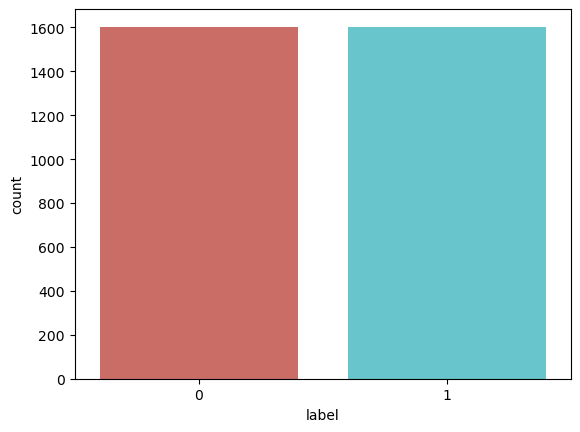

In [32]:
def create_distribution(dataFile):
    return sb.countplot(x='label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(news_dataset)

### <font color=orange> TF-IDF Vectorizer

In [36]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [37]:
print(X)

  (0, 33438)	0.056586919032274474
  (0, 33425)	0.06102796906598855
  (0, 33042)	0.05245042447593645
  (0, 32266)	0.07602923392006698
  (0, 32053)	0.06631295487517427
  (0, 31122)	0.08549093898435971
  (0, 30544)	0.06721167612667434
  (0, 30453)	0.0690716934551693
  (0, 30103)	0.201635028380023
  (0, 30023)	0.06057447881438142
  (0, 29888)	0.0663950923616471
  (0, 29882)	0.16118196057545875
  (0, 29551)	0.0813544444280217
  (0, 29470)	0.024984597684209287
  (0, 29458)	0.05932370821097343
  (0, 29186)	0.09471958205104092
  (0, 29047)	0.07733720272878898
  (0, 28712)	0.05752929786643764
  (0, 28110)	0.11466118202089924
  (0, 27807)	0.0699067380378554
  (0, 27789)	0.07271043803387951
  (0, 27518)	0.05467701480316709
  (0, 27331)	0.05306890782532698
  (0, 26201)	0.0541911205512738
  (0, 25272)	0.03882041991629
  :	:
  (3205, 20854)	0.048574091482072125
  (3205, 20361)	0.2164103297344587
  (3205, 18787)	0.08100835091760125
  (3205, 18659)	0.1167077794698881
  (3205, 18583)	0.2164103297344587

### Splitting the Dataset

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

### <font color=pink> Scores Function </font>

In [87]:
def scores(model, X_train, Y_train, X_test, Y_test):
    # Training Set Metrics
    X_train_prediction = model.predict(X_train)
    cm_train = metrics.confusion_matrix(Y_train, X_train_prediction)
    recall_train = metrics.recall_score(Y_train, X_train_prediction)
    f1_train = metrics.f1_score(Y_train, X_train_prediction)
    accuracy_train = metrics.accuracy_score(Y_train, X_train_prediction)   

    # Testing Set Metrics
    X_test_prediction = model.predict(X_test)
    cm_test = metrics.confusion_matrix(Y_test, X_test_prediction)
    recall_test = metrics.recall_score(Y_test, X_test_prediction)
    f1_test = metrics.f1_score(Y_test, X_test_prediction)
    accuracy_test = metrics.accuracy_score(Y_test, X_test_prediction)  

    # Return results in a dictionary
    return {
        'Training Set': {
            'Accuracy': accuracy_train, 
            'Confusion Matrix': cm_train,
            'Recall': recall_train,
            'F1-Score': f1_train,
        },
        'Testing Set': {
            'Accuracy': accuracy_test,  
            'Confusion Matrix': cm_test,
            'Recall': recall_test,
            'F1-Score': f1_test,
        }
    }
def print_scores_table(scores_dict):
    print('Evaluation Metrics:')
    for dataset, metrics in scores_dict.items():
        print(f"\n{dataset}:")
        print("Accuracy:", metrics['Accuracy']) 
        print("Confusion Matrix:\n", metrics['Confusion Matrix'])
        print("Recall:", metrics['Recall'])
        print("F1-Score:", metrics['F1-Score'])

### <font color=pink> Confusion Matrix Plot Function </font>

In [140]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Training the model

## <font color=violet> Logistic Regression</font>

In [72]:
LR_model = LogisticRegression()

In [73]:
LR_model = LR_model.fit(X_train, Y_train) 

### <font color=purple> Performance Evaluation</font>

In [141]:
LR_evaluation_scores = scores(LR_model, X_train, Y_train, X_test, Y_test)
print_scores_table(LR_evaluation_scores)

Evaluation Metrics:

Training Set:
Accuracy: 0.9699687987519501
Confusion Matrix:
 [[1266   16]
 [  61 1221]]
Recall: 0.9524180967238689
F1-Score: 0.9694323144104803

Testing Set:
Accuracy: 0.9236760124610592
Confusion Matrix:
 [[312   9]
 [ 40 281]]
Recall: 0.8753894080996885
F1-Score: 0.9198036006546645


Accuracy: 92.37%
Confusion matrix, without normalization


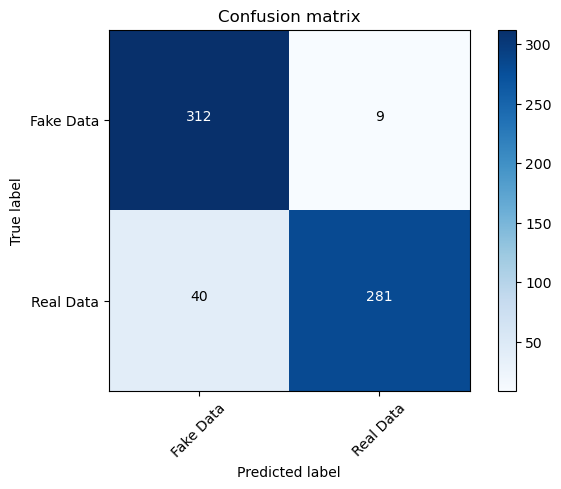

In [75]:
#accuracy score on the test data
Y_pred = LR_model.predict(X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['Fake Data', 'Real Data'])

### <font color=green> Making a Predictive Model</font>

In [36]:
X_new_LR = X_test[2]

prediction_LR = LR_model.predict(X_new_LR)
print(prediction_LR)

if (prediction_LR[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


### <font color=violet> K-Nearest Neighbors Classifier</font>

In [78]:
KNN_model = KNeighborsClassifier()

In [79]:
KNN_model = KNN_model.fit(X_train, Y_train) 

### <font color=purple> Performance Evaluation</font>

In [88]:
KNN_evaluation_scores = scores(KNN_model, X_train, Y_train, X_test, Y_test)
print_scores_table(KNN_evaluation_scores)

Evaluation Metrics:

Training Set:
Accuracy: 0.9110764430577223
Confusion Matrix:
 [[1099  183]
 [  45 1237]]
Recall: 0.9648985959438378
F1-Score: 0.9156180606957809

Testing Set:
Accuracy: 0.8551401869158879
Confusion Matrix:
 [[241  80]
 [ 13 308]]
Recall: 0.9595015576323987
F1-Score: 0.8688293370944993


Accuracy: 85.51%
Confusion matrix, without normalization


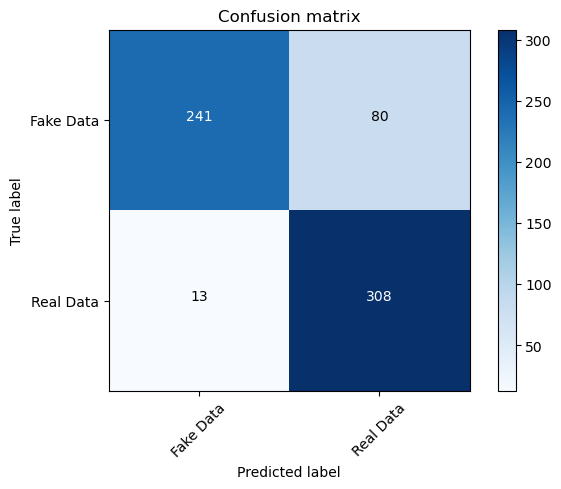

In [81]:
#accuracy score on the test data
Y_pred = KNN_model.predict(X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['Fake Data', 'Real Data'])

### <font color=green> Making a Predictive Model</font>

In [82]:
X_new_KNN = X_test[3]

prediction_KNN = KNN_model.predict(X_new_KNN)
print(prediction_KNN)

if (prediction_KNN[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


### <font color=violet> Support Vector Machine </font>

In [83]:
SVM_model = svm.SVC(probability=True)

In [84]:
SVM_model = SVM_model.fit(X_train, Y_train) 

### <font color=purple> Performance Evaluation</font>

In [85]:
SVM_evaluation_scores = scores(SVM_model, X_train, Y_train, X_test, Y_test)
print_scores_table(SVM_evaluation_scores)

Evaluation Metrics:

Training Set:
Accuracy: 0.999609984399376
Recall: 0.999219968798752
F1-Score: 0.999609832227858

Testing Set:
Accuracy: 0.9330218068535826
Recall: 0.881619937694704
F1-Score: 0.9293924466338259


Accuracy: 93.3%
Confusion matrix, without normalization


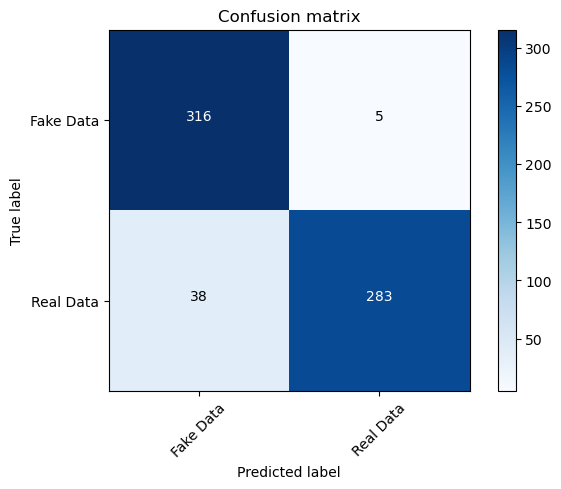

In [86]:
#accuracy score on the test data
Y_pred = SVM_model.predict(X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['Fake Data', 'Real Data'])

### <font color=green> Making a Predictive Model</font>

In [48]:
X_new_SVM = X_test[2]

prediction_SVM = SVM_model.predict(X_new_SVM)
print(prediction_SVM)

if (prediction_SVM[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


### <font color=violet> Decision Tree</font>

In [49]:
# applying Pre-Pruning techniques to control tree complexity during the growth phase
DT_model = tree.DecisionTreeClassifier(           
      max_depth=3,          # limiting the depth of the tree
      min_samples_split=5,  # minimum samples to create a split
      min_samples_leaf=2    # minimum samples in a leaf node 
)

In [50]:
DT_model = DT_model.fit(X_train, Y_train) 

### <font color=purple> Performance Evaluation</font>

In [51]:
DT_evaluation_scores = scores(DT_model, X_train, Y_train, X_test, Y_test)
print_scores_table(DT_evaluation_scores)

Evaluation Metrics:

Training Set:
Accuracy: 0.9017160686427457
Confusion Matrix:
 [[1183   99]
 [ 153 1129]]
Recall: 0.8806552262090483
F1-Score: 0.899601593625498

Testing Set:
Accuracy: 0.9049844236760125
Confusion Matrix:
 [[297  24]
 [ 37 284]]
Recall: 0.8847352024922118
F1-Score: 0.9030206677265501


In [ ]:
#accuracy score on the test data
Y_pred = KNN_model.predict(X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['Fake Data', 'Real Data'])

### <font color=green> Making a Predictive Model</font>

In [52]:
X_new_DT = X_test[3]
prediction_DT = DT_model.predict(X_new_DT)
print(prediction_DT)

if (prediction_DT[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


### <font color=violet> Multinomial Naive Bayes</font>

In [57]:
MNB_model = MultinomialNB() 

In [58]:
MNB_model = MNB_model.fit(X_train, Y_train) 

### <font color=purple> Performance Evaluation</font>

In [59]:
MNB_evaluation_scores = scores(MNB_model, X_train, Y_train, X_test, Y_test)
print_scores_table(MNB_evaluation_scores)

Evaluation Metrics:

Training Set:
Accuracy: 0.9512480499219969
Confusion Matrix:
 [[1164  118]
 [   7 1275]]
Recall: 0.9945397815912637
F1-Score: 0.9532710280373832

Testing Set:
Accuracy: 0.8535825545171339
Confusion Matrix:
 [[241  80]
 [ 14 307]]
Recall: 0.956386292834891
F1-Score: 0.867231638418079


In [ ]:
#accuracy score on the test data
Y_pred = KNN_model.predict(X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['Fake Data', 'Real Data'])

### <font color=green> Making a Predictive Model</font>

In [60]:
X_new_MNB = X_test[3]

prediction_MNB = LR_model.predict(X_new_MNB)
print(prediction_MNB)

if (prediction_MNB[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real
